In [1]:
'''
修改数据文件目录后可直接运行
参数设置有，测试日期，训练天数，测试天数
总的项目天数为1399天
'''


import os
file_list=[]
def file_name(file_dir):
    for root, dirs, files in os.walk(file_dir):
        for i in files:
            if (root+i)[-2:]=='gz':
                path=(root+'/'+i).replace('\\','/')
                file_list.append(path)
#在这里输入数据目录
file_name('C:/Users/zhouj/Desktop/dpdump/')

In [2]:
#参数设置
test_date=210
train_period=100
test_period=20

import pandas as pd
import numpy as np
import gzip
import os
import time
import datetime

def unzip(file_name):
    f_name = file_name.replace(".gz", "")
    g_file = gzip.GzipFile(file_name)
    open(f_name, "w+").write(g_file.read().decode('utf-8'))
    g_file.close()

def updown_10(x):
    a=0
    n=0
    for num in range(10):
        if x['r_'+str(num)]>0:
            a+=1
        if x['r_'+str(num)]!=0:
            n+=1
    return a/n

def train_mean(x,num_range):
    n=0
    a=0
    for num in range(num_range):
        if x['dv_'+str(num)]!=0:
            a+=x['dv_'+str(num)]
            n+=1
    return a/n

def OBV_cal(x,obv_num):
    return np.sign(x['r_'+str(obv_num)])*x['dv_'+str(obv_num)]
    
def loadfile(file):
    unzip(file)
    df= pd.read_csv(file.replace(".gz", ""))
    df=df[~df['r_0'].isnull()]
    df=df[~df['y'].isnull()]
    df=df[~df['dv_0'].isnull()]
    for num in range(50):
        df['r_'+str(num)].fillna(0, inplace=True)
    
    #3日，10日，50日涨跌幅
    df.eval('r_3_mean=(1+r_0)*(1+r_1)*(1+r_2)-1', inplace=True)
    df.eval('r_10_mean=(1+r_0)*(1+r_1)*(1+r_2)*(1+r_3)*(1+r_4)*(1+r_5)*(1+r_6)*(1+r_7)*(1+r_8)*(1+r_9)*(1+r_10)-1', inplace=True)
    temp_r='(1+r_'
    for num in range(25):
        temp_r=temp_r+str(num)+')*(1+r_'
    df.eval('r_25_mean='+temp_r[:-6], inplace=True)
    temp_r='(1+r_'
    for num in range(25,50):
        temp_r=temp_r+str(num)+')*(1+r_'
    df.eval('r_50_mean=r_25_mean*'+temp_r[:-6]+'-1', inplace=True)
    
    #10日涨跌比率
    df['ADR']=df.apply(updown_10, axis=1)
    
    for num in range(50):
        df['dv_'+str(num)].fillna(0, inplace=True)
    
    #3日，10日，50日平均交易金额
    df['dv_3_mean']=df.apply(train_mean, axis=1,num_range=3)
    df['dv_10_mean']=df.apply(train_mean, axis=1,num_range=10)
    df['dv_50_mean']=df.apply(train_mean, axis=1,num_range=50)
    
    
    #昨日交易金额与3日平均值的变动
    df.eval('dv_0_3_differ=dv_0-dv_3_mean', inplace=True)
    df.eval('dv_0_50_differ=dv_0-dv_50_mean', inplace=True)
    
    #过去三日量价关系
    #df['r_dv']=df.apply(r_dv, axis=1)
    
    
    #OBV指标，实则为交叉项
    for num in range(10):
        df['OBV_'+str(num)]=df.apply(OBV_cal,axis=1,obv_num=num)
    #OBV变动
    df.eval('OBV_3_total=OBV_0+OBV_1+OBV_2', inplace=True)
    df.eval('OBV_6_total=OBV_0+OBV_1+OBV_2+OBV_3+OBV_4+OBV_5', inplace=True)
    df.eval('OBV_10_total=OBV_0+OBV_1+OBV_2+OBV_3+OBV_4+OBV_5+OBV_6+OBV_7+OBV_8+OBV_9', inplace=True)
    
    #beta处理
    #行业3日，10日，50日涨跌幅
    industry_3_mean=pd.DataFrame(df.groupby('industry')['r_3_mean'].mean()).reset_index()
    industry_3_mean.rename(columns={'r_3_mean':'industry_3_mean'}, inplace = True)
    industry_10_mean=pd.DataFrame(df.groupby('industry')['r_10_mean'].mean()).reset_index()
    industry_10_mean.rename(columns={'r_10_mean':'industry_10_mean'}, inplace = True)
    industry_50_mean=pd.DataFrame(df.groupby('industry')['r_50_mean'].mean()).reset_index()
    industry_50_mean.rename(columns={'r_50_mean':'industry_50_mean'}, inplace = True)
    df=pd.merge(df,industry_3_mean, on=['industry'], how="outer")
    df=pd.merge(df,industry_10_mean, on=['industry'], how="outer")
    df=pd.merge(df,industry_50_mean, on=['industry'], how="outer")
    df.eval('beta_industry_3_mean=indbeta*industry_3_mean', inplace=True)
    df.eval('beta_industry_10_mean=indbeta*industry_10_mean', inplace=True)
    df.eval('beta_industry_50_mean=indbeta*industry_50_mean', inplace=True)
    
    #市场3日，10日，50日涨跌幅
    market_3_mean=df['r_3_mean'].mean()
    market_10_mean=df['r_10_mean'].mean()
    market_50_mean=df['r_50_mean'].mean()
    df['beta_market_3_mean']=df['beta']*market_3_mean
    df['beta_market_10_mean']=df['beta']*market_10_mean
    df['beta_market_50_mean']=df['beta']*market_50_mean
    
    weeklist=[0,0,0,0,0,0,0]
    #星期
    whatday= datetime.datetime.strptime(file[-22:-12],'%Y/%m/%d').strftime("%w")
    weeklist[int(whatday)]=1
    
    
    x_variable=['r_0','r_10_mean','r_50_mean','ADR','r_3_mean','dv_0','dv_0_3_differ','dv_0_50_differ','OBV_3_total','OBV_10_total','beta_industry_3_mean','beta_industry_10_mean', 'beta_industry_50_mean', 'beta_market_3_mean','beta_market_10_mean', 'beta_market_50_mean','f_0','f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8','f_9','industry','w']
    data=df[x_variable+['y']].dropna()
    Y=data[['y','w']]
    X=data[x_variable]
    X=X.join(pd.get_dummies(data['industry']))
    Y.eval('y=y*w',inplace=True)
    Y.drop('w',axis=1,inplace=True)
    for i in x_variable:
        X.eval(i+'='+i+'*w',inplace=True)
    X.drop(['w','industry'],axis=1,inplace=True)
    X=X.reset_index().drop(['index'],axis=1)
    Y=Y.reset_index().drop(['index'],axis=1)

    #print(X.columns.values.tolist())
    #正态化处理
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    split_line=26
    temp_X = sc.fit_transform(X.iloc[:,:split_line])
    temp_X = sc.transform(X.iloc[:,:split_line])
    X=X.iloc[:,split_line:].join(pd.DataFrame(temp_X,columns=x_variable[:split_line])).drop(1,axis=1)
    for num in range(2,6):
        X['week'+str(num)]=weeklist[num]

    return X,Y

pd.set_option('mode.chained_assignment', None)

X_train=pd.DataFrame()
Y_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_test=pd.DataFrame()

timeline=0
print('开始载入数据')
long=train_period+test_period
for i in range(test_date-train_period,test_date):
    temp_X,temp_Y=loadfile(file_list[i])
    X_train=pd.concat([X_train,temp_X])
    Y_train=pd.concat([Y_train,temp_Y])
    timeline+=1
    if timeline%10==0:
        print('已载入'+str(int(timeline*100/long))+'%')
for j in range(test_date,test_date+test_period):
    temp_X,temp_Y=loadfile(file_list[j])
    X_test=pd.concat([X_test,temp_X])
    Y_test=pd.concat([Y_test,temp_Y])
    timeline+=1
    if timeline%10==0:
        print('已载入'+str(int(timeline*100/long))+'%')


开始载入数据
已载入8%
已载入16%
已载入25%
已载入33%
已载入41%
已载入50%
已载入58%
已载入66%
已载入75%
已载入83%
已载入91%
已载入100%


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


C:\Users\zhouj\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zhouj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


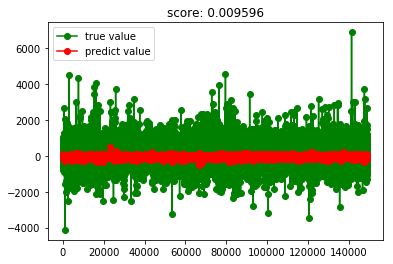

LassoLarsCV(copy_X=True, cv='warn', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=None,
      normalize=True, positive=False, precompute='auto', verbose=False)


C:\Users\zhouj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zhouj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


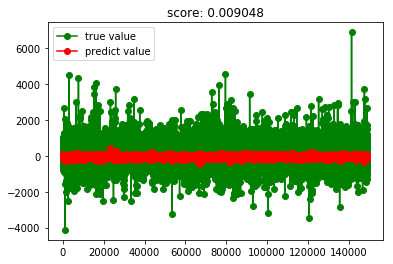

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


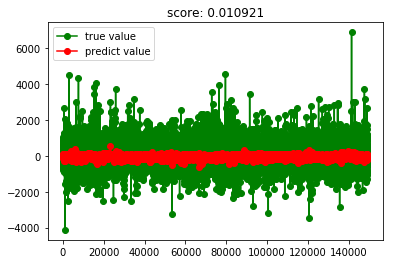

"\ntry_different_method(tree_reg)\nrf =ensemble.RandomForestRegressor(n_estimators=20)\ntry_different_method(rf)\nMLP = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)\ntry_different_method(MLP)\n"

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import ensemble
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

%matplotlib inline

def try_different_method(clf):
    print(clf)
    clf.fit(X_train,Y_train)
    result = clf.predict(X_train)
    score=r2_score(Y_train,result)
    plt.figure()
    plt.plot(np.arange(len(result)), Y_train,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('score: %f'%score)
    plt.legend()
    plt.show()


'''
def try_different_method(clf):
    print(clf)
    clf.fit(X_train,Y_train)
    result = clf.predict(X_test)
    score=r2_score(Y_test,result)
    
    plt.figure()
    plt.plot(np.arange(len(result)), Y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('score: %f'%score)
    plt.legend()
    plt.show()
'''
model = LassoCV()
try_different_method(model)
model = LassoLarsCV()
try_different_method(model)
linear_reg = linear_model.LinearRegression()
try_different_method(linear_reg)
tree_reg = tree.DecisionTreeRegressor()


'''
try_different_method(tree_reg)
rf =ensemble.RandomForestRegressor(n_estimators=20)
try_different_method(rf)
MLP = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
try_different_method(MLP)
'''